In [1]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
from sklearn.metrics import average_precision_score

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_test_transform, CUB_train_transform
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

# Standard model performance

# images: 11780
filename: /data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/174.Palm_Warbler/Palm_Warbler_0046_169837.jpg
image id: 10206
class id: 174
bird name: 174.Palm_Warbler
is_test: 1
image size: (456, 500, 3)


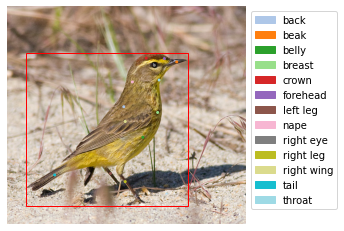

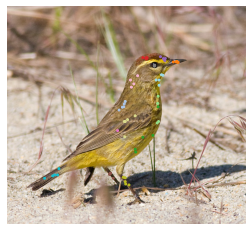

--------------- represented in dataset
image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


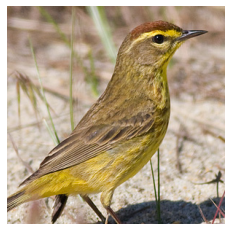

In [2]:
cub = CUB()
print('# images:', len(cub)) # should be 11788 - 8 (-8 b/c 8 gray scale images)

train_indices = [i for i in range(len(cub)) if not is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
test_indices = [i for i in range(len(cub)) if is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
cub_train = CUB_train_transform(Subset(cub, train_indices))
cub_test = CUB_test_transform(Subset(cub, test_indices))

def show_cub_data(dataset, idx):
    filename = dataset[idx]['filename']
    describe_bird(filename)

    print('--------------- represented in dataset')
    im, y = dataset[idx]['x'].permute(1,2,0), dataset[idx]['y'] 
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()
    
show_cub_data(cub_test, 30)

In [3]:
# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(SubColumn(cub_train, ['x', 'y']), batch_size=32, shuffle=True, num_workers=8)
loader_xy_te = DataLoader(SubColumn(cub_test, ['x', 'y']), batch_size=32, shuffle=False, num_workers=8)

image size: torch.Size([3, 299, 299])
0-indexed class id (describe bird is 1-indexed): 173


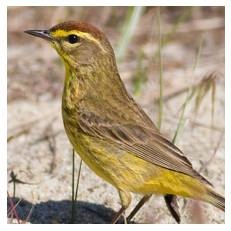

image size: torch.Size([3, 200, 200])
0-indexed class id (describe bird is 1-indexed): 173


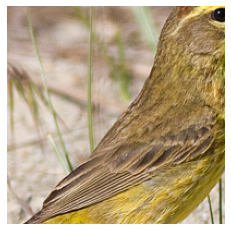

image size: torch.Size([1, 299, 299])
0-indexed class id (describe bird is 1-indexed): 173


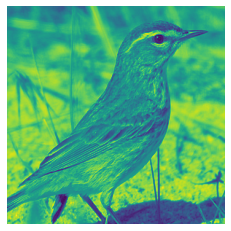

image size: torch.Size([3, 299, 299])
0-indexed class id (describe bird is 1-indexed): 173


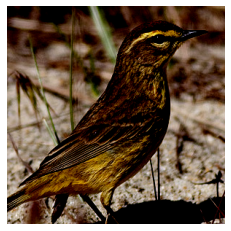

image size: torch.Size([3, 299, 299])
0-indexed class id (describe bird is 1-indexed): 173


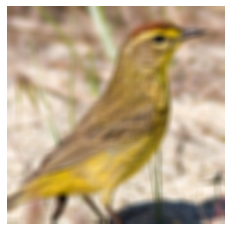

image size: torch.Size([3, 200, 200])
0-indexed class id (describe bird is 1-indexed): 173


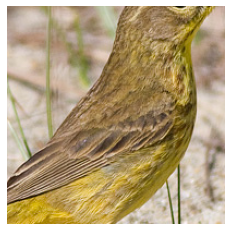

In [4]:
from torchvision.transforms import GaussianBlur, CenterCrop, ColorJitter, Grayscale, RandomCrop, RandomHorizontalFlip

def show_transform(dataset, idx, transform=lambda x: x):
    im, y = dataset[idx]['x'], dataset[idx]['y'] 
    im = transform(im)
    print('image size:',  im.shape)    
    im = im.permute(1,2,0)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()


show_transform(cub_test, 30, transform=lambda x: RandomHorizontalFlip(1)(x))
show_transform(cub_test, 30, transform=lambda x: RandomCrop(200)(x))
show_transform(cub_test, 30, transform=lambda x: Grayscale()(x))
show_transform(cub_test, 30, transform=lambda x: ColorJitter(brightness=32/255, saturation=(0.5, 1.5))(x))
show_transform(cub_test, 30, transform=lambda x: GaussianBlur(11, (10,20))(x))
show_transform(cub_test, 30, transform=lambda x: CenterCrop(200)(x))


# regularization

In [29]:
def attribution_ratio(attribution, concept_indices):
    '''
    attribution assumed to be (n_classes, n_concepts)
    concept_indices: indices of concepts
    '''
    ratio = attribution[:, concept_indices].abs().sum() / attribution.abs().sum()
    return ratio.item()

net = torch.load('../outputs/4ceae3dedd0e11ebb773ac1f6b24a434/ccm.pt') # ccm ind
n_concepts = 108
attribution = net.net_y[1].weight # (n_classes, n_concepts)
print('concept ratio', attribution_ratio(attribution, torch.arange(n_concepts)))
print('average precision', average_precision_score(torch.cat([torch.ones(n_concepts), torch.zeros(attribution.shape[1]-n_concepts)]).numpy(), 
                                                   attribution.abs().sum(0).detach().cpu().numpy()))

concept ratio 0.3808431029319763
average precision 0.6532809641266222


In [50]:
net = torch.load('../outputs/25f46764dd0e11ebb773ac1f6b24a434/ccm.pt') # ccm seq
n_concepts = 108
attribution = net.net_y[1].weight # (n_classes, n_concepts)
print('concept ratio', attribution_ratio(attribution, torch.arange(n_concepts)))
print('average precision', average_precision_score(torch.cat([torch.ones(n_concepts), torch.zeros(attribution.shape[1]-n_concepts)]).numpy(), 
                                                   attribution.abs().sum(0).detach().cpu().numpy()))

concept ratio 0.3311097025871277
average precision 0.3322831620439636


In [51]:
net = torch.load('../outputs/21aeff22de2411ebb773ac1f6b24a434/ccm.pt') # ccm seq alpha 1e-2

n_concepts = 108
attribution = net.net_y[1].weight # (n_classes, n_concepts)
print('concept ratio', attribution_ratio(attribution, torch.arange(n_concepts)))
print('average precision', average_precision_score(torch.cat([torch.ones(n_concepts), torch.zeros(attribution.shape[1]-n_concepts)]).numpy(), 
                                                   attribution.abs().sum(0).detach().cpu().numpy()))

concept ratio 0.9863741397857666
average precision 1.0000000000000002


In [52]:
net = torch.load('../outputs/24df0006de2511ebb773ac1f6b24a434/ccm.pt') # ccm seq 1e-3
n_concepts = 108
attribution = net.net_y[1].weight # (n_classes, n_concepts)
print('concept ratio', attribution_ratio(attribution, torch.arange(n_concepts)))
print('average precision', average_precision_score(torch.cat([torch.ones(n_concepts), torch.zeros(attribution.shape[1]-n_concepts)]).numpy(), 
                                                   attribution.abs().sum(0).detach().cpu().numpy()))

concept ratio 0.8827211260795593
average precision 1.0000000000000002


In [53]:
net = torch.load('../outputs/3c541640de2511ebb773ac1f6b24a434/ccm.pt') # ccm seq 1e-4
n_concepts = 108
attribution = net.net_y[1].weight # (n_classes, n_concepts)
print('concept ratio', attribution_ratio(attribution, torch.arange(n_concepts)))
print('average precision', average_precision_score(torch.cat([torch.ones(n_concepts), torch.zeros(attribution.shape[1]-n_concepts)]).numpy(), 
                                                   attribution.abs().sum(0).detach().cpu().numpy()))

concept ratio 0.5163990259170532
average precision 1.0000000000000002


In [54]:
net = torch.load('../outputs/762ae4dede2511ebb773ac1f6b24a434/ccm.pt') # ccm seq 1e-5
n_concepts = 108
attribution = net.net_y[1].weight # (n_classes, n_concepts)
print('concept ratio', attribution_ratio(attribution, torch.arange(n_concepts)))
print('average precision', average_precision_score(torch.cat([torch.ones(n_concepts), torch.zeros(attribution.shape[1]-n_concepts)]).numpy(), 
                                                   attribution.abs().sum(0).detach().cpu().numpy()))

concept ratio 0.34563055634498596
average precision 0.4091656729421643


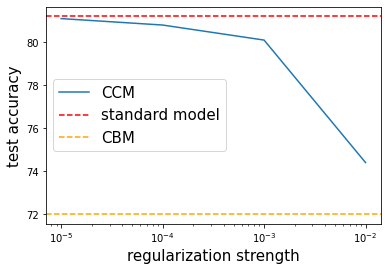

In [65]:
alphas = [1e-2, 1e-3, 1e-4, 1e-5]
accs = [74.4, 80.1, 80.8, 81.1]
concept_ratios = [0.986, 0.883, 0.516, 0.346]
AP = [1, 1, 1, 0.409]

# 0:      81.2 0.331 0.332
# 1e-5: 81.1 0.346 0.409
# 1e-4: 80.8 0.516 1.00
# 1e-3: 80.1 0.883 1.00
# 1e-2: 74.4 0.986 1.00

plt.semilogx(alphas, accs, label='CCM')
plt.axhline(81.2, ls='--', color='red', label='standard model')
plt.axhline(72.0, ls='--', color='orange', label='CBM')
plt.legend(fontsize=15)
plt.xlabel('regularization strength', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)
plt.show()


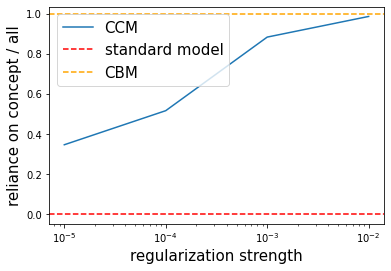

In [68]:
plt.semilogx(alphas, concept_ratios, label='CCM')
plt.axhline(0, ls='--', color='red', label='standard model')
plt.axhline(1.0, ls='--', color='orange', label='CBM')
plt.legend(fontsize=15)
plt.xlabel('regularization strength', fontsize=15)
plt.ylabel('reliance on concept / all', fontsize=15)
plt.show()


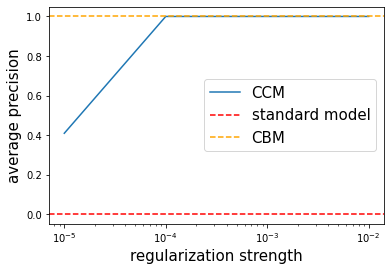

In [69]:
plt.semilogx(alphas, AP, label='CCM')
plt.axhline(0, ls='--', color='red', label='standard model')
plt.axhline(1.0, ls='--', color='orange', label='CBM')
plt.legend(fontsize=15)
plt.xlabel('regularization strength', fontsize=15)
plt.ylabel('average precision', fontsize=15)
plt.show()


# Incomplete concepts

test eval: 100%|██████████| 91/91 [00:07<00:00, 12.10it/s]


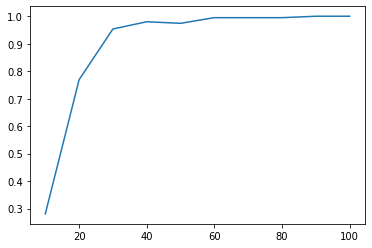

In [241]:
loader_xy_te = DataLoader(SubColumn(cub_test, ['attr', 'y']), batch_size=64, shuffle=False, num_workers=8)

accs = []
n_concepts = []
for n_concept in range(10, 101, 10):
    # log = torch.load(f'../outputs/concepts/gt_{n_concept}.log')
    net = torch.load(f'../outputs/concepts/gt_{n_concept}.pt')
    net = net.to('cpu')
    n_concepts.append(n_concept)
    # accs.append(log[-1]['val acc'])
    accs.append(test(net, loader_xy_te, acc_criterion, device='cpu'))
    
plt.plot(n_concepts, accs)

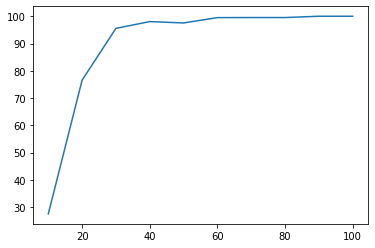

In [247]:
val_accs = []
n_concepts = []
for n_concept in range(10, 101, 10):
    log = torch.load(f'../outputs/concepts/gt_{n_concept}.log')
    n_concepts.append(n_concept)
    val_accs.append(log[-1]['train acc'])
    
plt.plot(n_concepts, val_accs)

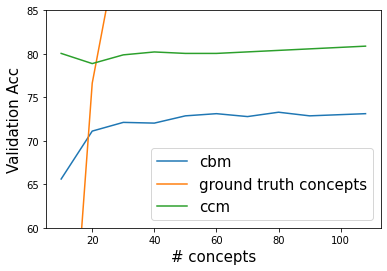

In [287]:
def sweep_concepts(fn_concepts, label=None):
    val_accs = []
    n_concepts = []
    for fn, n_concept in fn_concepts:
        log = torch.load(f'{fn}.log')
        n_concepts.append(n_concept)
        val_accs.append(log[-1]['val acc'])

    plt.plot(n_concepts, val_accs, label=label)

fn_gt_concepts = [
    ("../outputs/concepts/gt_10", 10),
    ("../outputs/concepts/gt_20", 20),
    ("../outputs/concepts/gt_30", 30),
    ("../outputs/concepts/gt_40", 40),
    ("../outputs/concepts/gt_50", 50),
    ("../outputs/concepts/gt_60", 60),
    ("../outputs/concepts/gt_70", 70),
    ("../outputs/concepts/gt_80", 80),
    ("../outputs/concepts/gt_90", 90),
    ("../outputs/concepts/gt_100", 100),    
]
fn_learned_concepts =[
    ("../outputs/learned_concepts/6bb4084ad86811ebb773ac1f6b24a434/cbm", 108),
    ("../outputs/learned_concepts/36178f0cd88811ebb773ac1f6b24a434/cbm", 90),
    ("../outputs/learned_concepts/31051b6ad88811ebb773ac1f6b24a434/cbm", 80),
    ("../outputs/learned_concepts/2acb8630d88811ebb773ac1f6b24a434/cbm", 70),
    ("../outputs/learned_concepts/27a7fa42d88811ebb773ac1f6b24a434/cbm", 60),    
    ("../outputs/learned_concepts/7fa43634d87411ebb773ac1f6b24a434/cbm", 50),
    ("../outputs/learned_concepts/766bb1b4d87411ebb773ac1f6b24a434/cbm", 40),
    ("../outputs/learned_concepts/6bd5a99ed87411ebb773ac1f6b24a434/cbm", 30),
    ("../outputs/learned_concepts/62071dc6d87411ebb773ac1f6b24a434/cbm", 20),
    ("../outputs/learned_concepts/1e7887f4d86811ebb773ac1f6b24a434/cbm", 10)]

fn_ccm_concepts = [
    ("../outputs/ccm_incomplete_concepts/4c23976ed89c11ebb773ac1f6b24a434/ccm", 108),
    ("../outputs/ccm_incomplete_concepts/8ff16e7cd8f011ebb773ac1f6b24a434/ccm", 60),
    ("../outputs/ccm_incomplete_concepts/8c5f62b4d8f011ebb773ac1f6b24a434/ccm", 50),
    ("../outputs/ccm_incomplete_concepts/88070aaad8f011ebb773ac1f6b24a434/ccm", 40),
    ("../outputs/ccm_incomplete_concepts/c42cffc6d8a011ebb773ac1f6b24a434/ccm", 30),
    ("../outputs/ccm_incomplete_concepts/743b7466d8a011ebb773ac1f6b24a434/ccm", 20),
    ("../outputs/ccm_incomplete_concepts/e940cd46d89c11ebb773ac1f6b24a434/ccm", 10),
]

sweep_concepts(fn_learned_concepts, 'cbm')
sweep_concepts(fn_gt_concepts, 'ground truth concepts')
sweep_concepts(fn_ccm_concepts, 'ccm')

plt.legend(fontsize=15)
plt.ylim(60, 85)
plt.ylabel('Validation Acc', fontsize=15)
plt.xlabel('# concepts', fontsize=15)
plt.show()

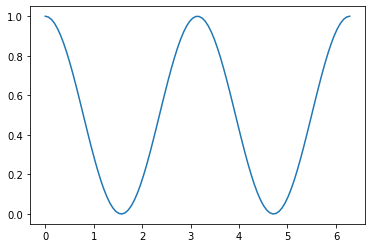

In [292]:
from lib.regularization import cosine_loss
loss = []
angles = np.linspace(0, 2 * np.pi, 100)
for i in angles:
    l = cosine_loss(torch.tensor([np.sin(i), np.cos(i)]).reshape(-1, 1).float(), torch.tensor([0.0, 1.0]).reshape(-1, 1))
    loss.append(l)
    
plt.plot(angles, loss)


# Playground

In [170]:
c_attr = get_class_attributes()
c_attr

,has_bill_shape::curved_(up_or_down),has_bill_shape::dagger,has_bill_shape::hooked,has_bill_shape::needle,has_bill_shape::hooked_seabird,has_bill_shape::spatulate,has_bill_shape::all-purpose,has_bill_shape::cone,has_bill_shape::specialized,has_wing_color::blue,...,has_crown_color::pink,has_crown_color::orange,has_crown_color::black,has_crown_color::white,has_crown_color::red,has_crown_color::buff,has_wing_pattern::solid,has_wing_pattern::spotted,has_wing_pattern::striped,has_wing_pattern::multi-colored
0,0.000000,2.919708,1.459854,0.000000,59.854015,26.277372,3.649635,5.839416,0.000000,1.639344,...,0.000000,0.000000,21.276596,11.347518,2.12766,31.914894,53.571429,5.357143,21.428571,19.642857
1,4.411765,4.411765,2.941176,1.470588,57.352941,27.205882,0.000000,2.205882,0.000000,0.000000,...,0.000000,2.255639,2.255639,94.736842,0.00000,0.000000,77.142857,3.809524,10.476190,8.571429
2,0.000000,3.973510,3.311258,0.000000,70.860927,14.569536,5.298013,1.986755,0.000000,0.000000,...,2.205882,0.000000,38.970588,2.941176,0.00000,16.176471,71.028037,0.934579,7.476636,20.560748
3,0.000000,1.459854,10.218978,0.000000,0.000000,0.000000,8.759124,25.547445,54.014599,5.839416,...,0.000000,0.000000,88.571429,0.000000,0.00000,2.142857,84.126984,2.380952,3.174603,10.317460
4,0.000000,0.000000,3.225806,0.000000,1.075269,0.000000,0.000000,32.258065,63.440860,0.000000,...,0.000000,0.000000,82.727273,5.454545,0.00000,4.545455,88.461538,0.000000,3.846154,7.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.702703,12.837838,0.000000,0.000000,0.000000,0.000000,76.351351,8.108108,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.973684,0.00000,29.605263,14.379085,22.875817,56.209150,6.535948
196,18.300654,11.764706,0.000000,3.267974,0.000000,0.000000,60.784314,5.882353,0.000000,0.000000,...,0.000000,0.000000,35.443038,4.430380,0.00000,22.784810,16.783217,25.174825,32.167832,25.874126
197,10.759494,36.708861,0.000000,7.594937,0.632911,0.000000,43.670886,0.632911,0.000000,0.000000,...,0.000000,0.000000,14.375000,13.125000,0.00000,41.875000,18.791946,44.295302,18.791946,18.120805
198,0.000000,2.068966,0.000000,2.068966,0.000000,0.000000,88.275862,7.586207,0.000000,0.000000,...,0.000000,1.324503,3.973510,0.000000,0.00000,19.205298,12.413793,34.482759,33.103448,20.000000


In [217]:
len(cub_data) / 200

58.9

In [203]:
cub_data = CUB(class_attr=False)
y2attr = np.zeros((200, 312))
n_y = np.zeros(200)
for d in cub_data:
    y2attr[d['y']] += d['attr'].numpy()
    n_y[d['y']] += 1
for i in range(200):
    y2attr[i] /= n_y[i]

In [206]:
c_attr2 = pd.DataFrame(y2attr * 100.0, columns=[get_attribute_name(i) for i in range(1, 313)])
c_attr2

,has_bill_shape::curved_(up_or_down),has_bill_shape::dagger,has_bill_shape::hooked,has_bill_shape::needle,has_bill_shape::hooked_seabird,has_bill_shape::spatulate,has_bill_shape::all-purpose,has_bill_shape::cone,has_bill_shape::specialized,has_wing_color::blue,...,has_crown_color::pink,has_crown_color::orange,has_crown_color::black,has_crown_color::white,has_crown_color::red,has_crown_color::buff,has_wing_pattern::solid,has_wing_pattern::spotted,has_wing_pattern::striped,has_wing_pattern::multi-colored
0,0.000000,3.333333,1.666667,0.000000,55.000000,25.000000,5.000000,5.000000,0.000000,1.666667,...,0.000000,0.000000,16.666667,13.333333,1.666667,30.000000,36.666667,3.333333,18.333333,21.666667
1,5.000000,5.000000,6.666667,1.666667,53.333333,21.666667,0.000000,1.666667,0.000000,0.000000,...,0.000000,1.666667,1.666667,85.000000,0.000000,0.000000,56.666667,3.333333,8.333333,6.666667
2,0.000000,5.172414,3.448276,0.000000,68.965517,13.793103,6.896552,1.724138,0.000000,0.000000,...,1.724138,0.000000,34.482759,3.448276,0.000000,13.793103,55.172414,1.724138,6.896552,17.241379
3,0.000000,1.666667,10.000000,0.000000,0.000000,0.000000,8.333333,25.000000,46.666667,5.000000,...,0.000000,0.000000,80.000000,0.000000,0.000000,1.666667,70.000000,1.666667,3.333333,8.333333
4,0.000000,0.000000,2.272727,0.000000,2.272727,0.000000,0.000000,29.545455,59.090909,0.000000,...,0.000000,0.000000,77.272727,4.545455,0.000000,4.545455,63.636364,0.000000,2.272727,6.818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,3.389831,13.559322,0.000000,0.000000,0.000000,0.000000,76.271186,6.779661,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.694915,0.000000,30.508475,13.559322,23.728814,54.237288,6.779661
196,20.000000,13.333333,0.000000,3.333333,0.000000,0.000000,58.333333,5.000000,0.000000,0.000000,...,0.000000,0.000000,33.333333,5.000000,0.000000,23.333333,16.666667,21.666667,31.666667,25.000000
197,10.000000,36.666667,0.000000,6.666667,1.666667,0.000000,43.333333,1.666667,0.000000,0.000000,...,0.000000,0.000000,13.333333,15.000000,0.000000,41.666667,18.333333,41.666667,20.000000,20.000000
198,0.000000,1.666667,0.000000,1.666667,0.000000,0.000000,90.000000,6.666667,0.000000,0.000000,...,0.000000,1.666667,3.333333,0.000000,0.000000,21.666667,13.333333,31.666667,35.000000,18.333333


In [231]:
np.array((c_attr > 0).astype('float') - (c_attr2 > 0).astype('float')).sum()

1.0

In [227]:
def maj_concepts(attr):
    '''attr: 200 x 312'''
    assert attr.shape == (200, 312), "must be 200x312 in shape"
    maj_vote = 50
    at_least_classes = 10
    return (attr.loc[:, ((attr >= maj_vote).sum(0) >= at_least_classes)] >= maj_vote)

maj_concepts(c_attr).shape

(200, 108)

# need to debug the above b/c c_attr and c_attr2 should match

Text(0, 0.5, 'accuracy')

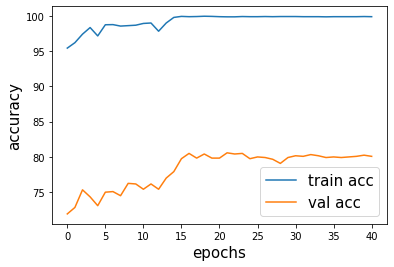

In [5]:
plot_log(torch.load('../outputs/13923cb6d58111ebb773ac1f6b24a434/ccm.log'), key='train acc')
plot_log(torch.load('../outputs/13923cb6d58111ebb773ac1f6b24a434/ccm.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

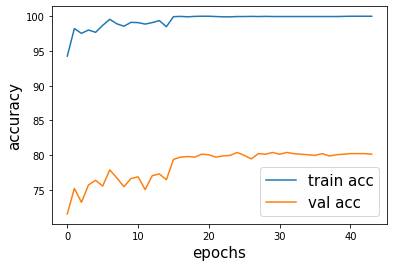

In [148]:
plot_log(torch.load('../outputs/d36bfb00d5ed11ebb773ac1f6b24a434/ccm.log'), key='train acc')
plot_log(torch.load('../outputs/d36bfb00d5ed11ebb773ac1f6b24a434/ccm.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

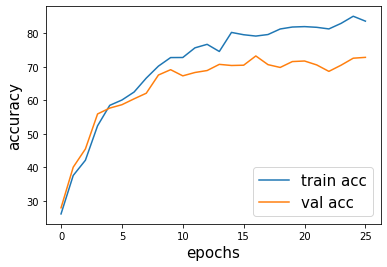

In [59]:
plot_log(torch.load('../models/standard.log'), key='train acc')
plot_log(torch.load('../models/standard.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

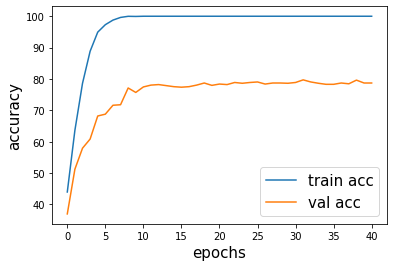

In [76]:
plot_log(torch.load('../models/standard_imagenet.log'), key='train acc')
plot_log(torch.load('../models/standard_imagenet.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

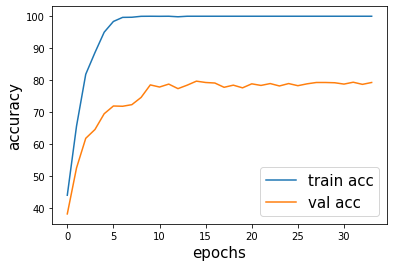

In [75]:
plot_log(torch.load('../models/standard_same.log'), key='train acc')
plot_log(torch.load('../models/standard_same.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

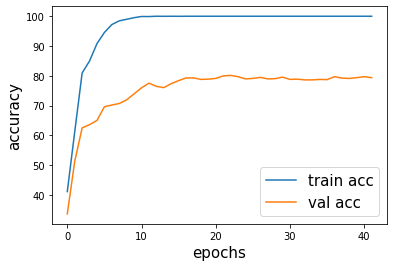

In [77]:
plot_log(torch.load('../models/standard_flip.log'), key='train acc')
plot_log(torch.load('../models/standard_flip.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

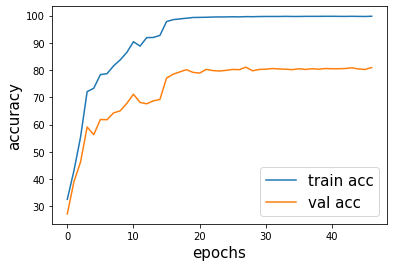

In [113]:
plot_log(torch.load('../models/standard_crop.log'), key='train acc')
plot_log(torch.load('../models/standard_crop.log'), key='val acc')
plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)
# plt.ylim(60, 100)

lr decay really helped

Text(0, 0.5, 'loss')

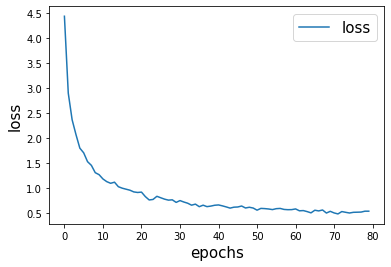

In [82]:
plot_log(torch.load('../models/standard_cbm.log'), key='loss')
plt.legend(fontsize=15)
plt.ylabel('loss', fontsize=15)

(70.0, 81.0)

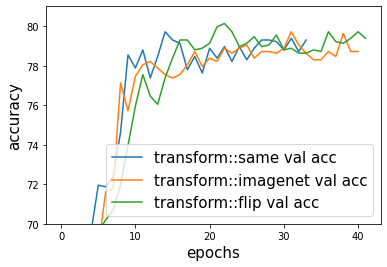

In [79]:
plot_log(torch.load('../models/standard_same.log'), key='val acc', ylabel='transform::same val acc')
plot_log(torch.load('../models/standard_imagenet.log'), key='val acc', ylabel='transform::imagenet val acc')
plot_log(torch.load('../models/standard_flip.log'), key='val acc', ylabel='transform::flip val acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.ylim([70, 81])

(70.0, 81.0)

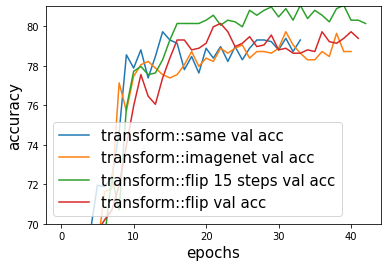

In [87]:
plot_log(torch.load('../model_backup/standard_same.log'), key='val acc', ylabel='transform::same val acc')
plot_log(torch.load('../model_backup/standard_imagenet.log'), key='val acc', ylabel='transform::imagenet val acc')
plot_log(torch.load('../models/standard_flip.log'), key='val acc', ylabel='transform::flip 15 steps val acc')
plot_log(torch.load('../model_backup/standard_flip.log'), key='val acc', ylabel='transform::flip val acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.ylim([70, 81])

(70.0, 82.0)

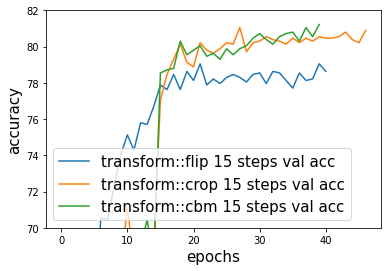

In [99]:
plot_log(torch.load('../models/standard_flip.log'), key='val acc', ylabel='transform::flip 15 steps val acc')
plot_log(torch.load('../models/standard_crop.log'), key='val acc', ylabel='transform::crop 15 steps val acc')
plot_log(torch.load('../models/standard_cbm.log'), key='val acc', ylabel='transform::cbm 15 steps val acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.ylim([70, 82])

Text(0, 0.5, 'accuracy')

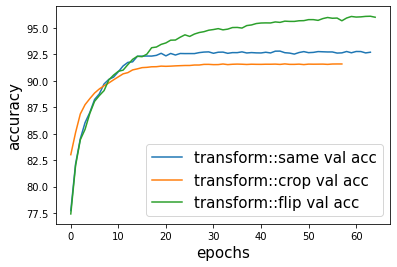

In [137]:
plot_log(torch.load('../models/concepts_same.log'), key='val acc', ylabel='transform::same val acc')
plot_log(torch.load('../models/concepts_crop.log'), key='val acc', ylabel='transform::crop val acc')
plot_log(torch.load('../models/concepts_flip.log'), key='val acc', ylabel='transform::flip val acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

don't need to lr decay

Text(0, 0.5, 'accuracy')

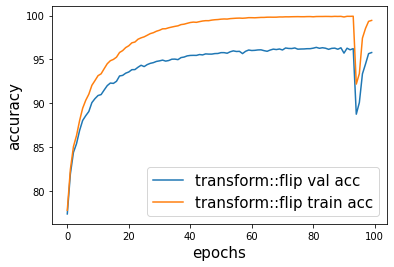

In [140]:
plot_log(torch.load('../models/concepts_flip.log'), key='val acc', ylabel='transform::flip val acc')
plot_log(torch.load('../models/concepts_flip.log'), key='train acc', ylabel='transform::flip train acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

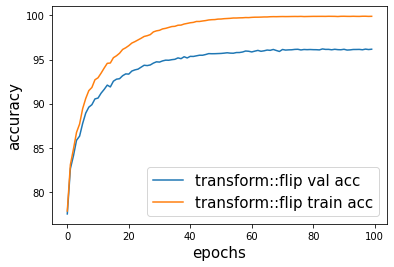

In [146]:
plot_log(torch.load('../models/concepts_flip.log'), key='val acc', ylabel='transform::flip val acc')
plot_log(torch.load('../models/concepts_flip.log'), key='train acc', ylabel='transform::flip train acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

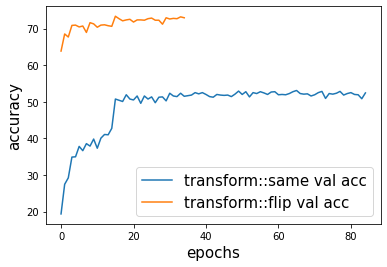

In [248]:
plot_log(torch.load('../models/cbm_same.log'), key='val acc', ylabel='transform::same val acc')
plot_log(torch.load('../models/cbm_flip.log'), key='val acc', ylabel='transform::flip val acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)

Text(0, 0.5, 'accuracy')

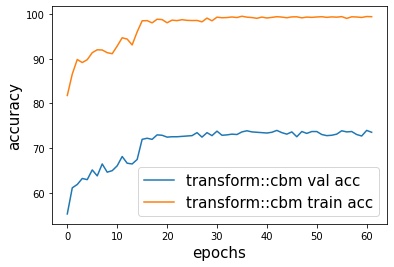

In [253]:
plot_log(torch.load('../models/cbm_cbm.log'), key='val acc', ylabel='transform::cbm val acc')
plot_log(torch.load('../models/cbm_cbm.log'), key='train acc', ylabel='transform::cbm train acc')

# plot_log(torch.load('../models/cbm_flip.log'), key='val acc', ylabel='transform::flip val acc')

plt.legend(fontsize=15)
plt.ylabel('accuracy', fontsize=15)